<a href="https://colab.research.google.com/github/Peter-Szigeti/Covid-Plotter/blob/main/Bayesian_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import operator

## Bayesian inference

### Lineáris adat

Adott egy zajos egyenes, melynek szeretnénk megtudni mind a meredekségét, mind a zajnak a mértékét.

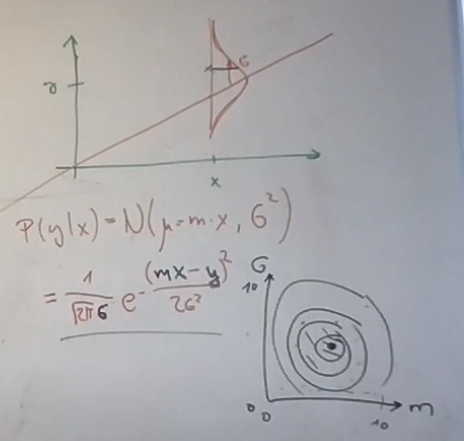

In [2]:
theta_true = 1 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 5 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + np.random.normal(0,sigma_true,m)

In [3]:
Normal = lambda  sigma, mu, y :  1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(y - mu)**2/(2*sigma**2))

### Lináris adat első próbálkozás

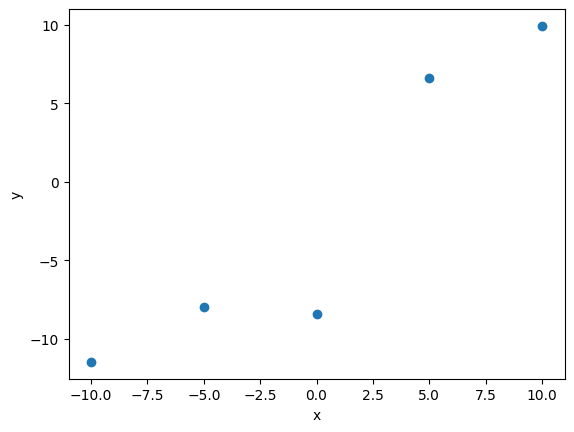

In [4]:
theta_true = 1 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 5 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + np.random.normal(0,sigma_true,m)

# egyenes ábrázolása
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
sigmas = np.arange(2, 10, 0.05)
thetas = np.arange(0.1, 2, 0.02)
prior = np.ones((len(thetas),len(sigmas)))
prior /=np.sum(prior)


In [6]:
def calculate_log_likelihood_for_datapoint(x_i,y_i):
  epsilon = 1e-8  # ez azért kell, hogy ne vegyük 0nak a logritmusát..
  log_likelihood_i = np.array([[np.log(Normal( sigma, x_i * theta, y_i ) + epsilon) for sigma in sigmas] for theta in thetas])
  return log_likelihood_i

In [7]:
log_likelihood = sum([calculate_log_likelihood_for_datapoint(x[i],y[i]) for i in range(len(x))])
unnorm_log_posterior = np.log(prior) + log_likelihood
unnorm_log_posterior = unnorm_log_posterior - np.max(unnorm_log_posterior)
MUALP_estimate = np.where(unnorm_log_posterior==np.max(unnorm_log_posterior)) # maximum nem normalizált log poszterior becslése az eredeti egyenesnek
MUALP_estimate

(array([52]), array([40]))

Azért vettem a log-ját a valószínúségeknek, mert annyira kicsiek voltak, hogy összeszorozva 0nak vette a python. Illetve ezért nem normalizáltam, az unnorm_log_posterior-okat, mert azokat is 0nak venné..

In [8]:
print("theta: ", thetas[MUALP_estimate[0][0]], "sigma: ", sigmas[MUALP_estimate[1][0]])

theta:  1.1400000000000003 sigma:  3.999999999999993


Az alábbi ábrán ábrázolom a kapott valószínúségi eloszlást egy színtérképpel. Kék ponttal ábrázolom, a legjobb becslésünket. Látszik, hogy visszakaptuk az eredeti paramétereit az egyenesnek.

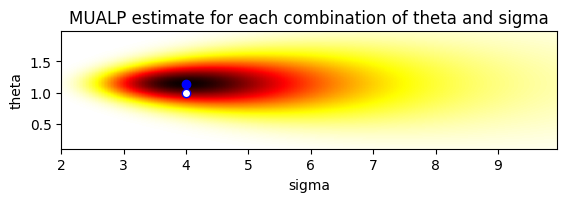

In [9]:

plt.imshow(np.exp(unnorm_log_posterior), cmap='hot_r', origin='lower', extent=[sigmas[0], sigmas[-1], thetas[0], thetas[-1]])
plt.xlabel('sigma')
plt.ylabel('theta')
# plt.xticks(np.arange(0,11,1), np.arange(0.5,6,0.5))
# plt.yticks(np.arange(0,11,1), np.arange(0.5,6,0.5))
plt.scatter(sigmas[MUALP_estimate[1][0]], thetas[MUALP_estimate[0][0]], color='blue', label='MAP estimate')
plt.scatter(sigma_true, theta_true, edgecolor='blue', facecolor='w', label='true')
plt.title('MUALP estimate for each combination of theta and sigma')
# plt.legend(loc='upper left')
plt.show()

### Lineáris adat egy függvénnyel
Nem hiszem, hogy gyorsabb viszont egyértelműbb mint a fenti és akármennyi paraméterrel használható

In [10]:
def bayesian_updating(x,y, prior, parameter_start, parameter_end, parameter_steps, assumed_true_mapping):
  for x_i, y_i in zip(x,y):
    for el in np.ndenumerate(prior):
      idx = el[0]
      parameters = parameter_start + parameter_steps * np.array(idx)
      epsilon = 1e-8  # ez azért kell, hogy ne vegyük 0nak a logritmusát..
      prior[idx] += np.log(Normal(parameters[-1], assumed_true_mapping(x_i, parameters), y_i) + epsilon)

  unnorm_posterior = np.exp(prior-np.max(prior))
  posterior = unnorm_posterior / np.max(unnorm_posterior)
  return posterior

In [11]:
# egyenként lehet definiálni a paraméterekre, hogy hol kezdődnek, hol végződnek és mekkora lépések vannak köztük
parameter_start = np.array([0.1, 0.1])
parameter_end = np.array([4,10])
parameter_steps = np.array([0.1,0.1])
parameter_shapes = np.array((parameter_end - parameter_start)/parameter_steps,dtype=int)

assumed_true_mapping = lambda x, parameters : parameters[0] * x # ez az a leképezés, amit feltételezünk, a likelihood-ok számolásánál
prior = np.log(np.ones(parameter_shapes)/np.product(parameter_shapes)) # prior, én uniformnak vettem
posterior = bayesian_updating(x,y,prior, parameter_start,parameter_end,parameter_steps, assumed_true_mapping)

MAP_estimate = np.where(posterior==np.max(posterior)) # látszik, hogy ugyanaz mint a fentebbiekben
print("theta: ",  MAP_estimate[0] * parameter_steps[0] + parameter_start[0], "sigma: ", MAP_estimate[1] * parameter_steps[1] + parameter_start[1])

theta:  [1.1] sigma:  [4.]


#### Kérdés: függ a meredekségre kapott megoldás a sigma értékétől?


úgy értem, hogy a sigmára kapott becslés értékétől függ-e a theta becsült értéke?

In [12]:
parameter_start = np.array([0.1, 0.1])
parameter_end = np.array([4,10])
parameter_steps = np.array([0.1,0.1])
parameter_shapes = np.array((parameter_end - parameter_start)/parameter_steps,dtype=int)

assumed_true_mapping = lambda x, parameters : parameters[0] * x # ez az a leképezés, amit feltételezünk, a likelihood-ok számolásánál
delta_theta = []
delta_sigma = []
for sigma_true_i in np.arange(0.1,10,0.5):
  theta_true = 1 # az egyenesünk egy darab paramétere
  m = 5 # adatpontok száma
  x = np.linspace(-10,10,m)
  y = theta_true*x + np.random.normal(0,sigma_true_i,m)

  prior = np.log(np.ones(parameter_shapes)/np.product(parameter_shapes)) # prior, én uniformnak vettem
  posterior = bayesian_updating(x,y,prior, parameter_start,parameter_end,parameter_steps, assumed_true_mapping)
  MAP_estimate = np.where(posterior==np.max(posterior))

  theta_h = MAP_estimate[0] * parameter_steps[0] + parameter_start[0]
  sigma_h = MAP_estimate[1] * parameter_steps[1] + parameter_start[1]

  delta_theta.append(abs(theta_true-theta_h))
  delta_sigma.append(abs(sigma_true_i-sigma_h))

Szerintem annak, hogy mennyire jól becsüli meg a modellünk a paraméterek(pl.theta) értékeit, nem kellene fügnie egy adott paraméter értékétől(pl.sigma). Mégis, ezen a szimuláción, meg az látszik, hogy nem monoton, de nő az eltérések értéke. Viszont ez lehet azért is, mert egyszerűen egy zajosabb leképezéshez több adatpontra lenne szükségünk, hogy megbecsüljük.

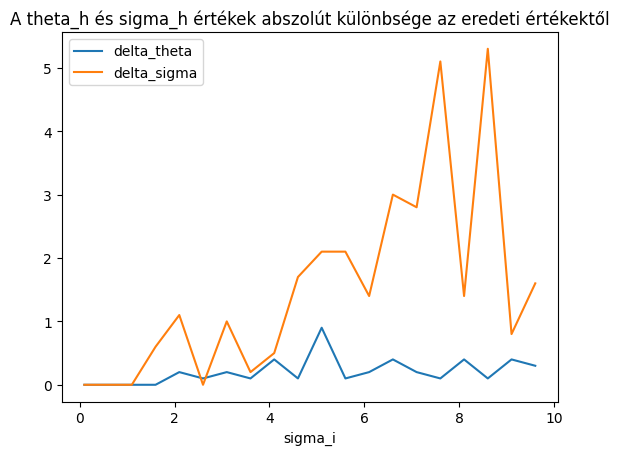

In [13]:
plt.plot(np.arange(.1, 10, .5), delta_theta)
plt.plot(np.arange(.1, 10, .5), delta_sigma)
plt.title("A theta_h és sigma_h értékek abszolút különbsége az eredeti értékektől")
plt.legend(["delta_theta", "delta_sigma"])
plt.xlabel("sigma_i")
plt.show()

#### 1. Megcsinálni ugyanezt (Bayesian model fitting) meredekség és tengelymetszetre.
Én zaj nélkül, annyira nem látom, hogy például hogy számolnám ki a likelihood-ot. Meg ha nincs zaj, akkor 2 adatpontból meg lehet mondani a meredekséget és a tengelymetszetet is. Esetleg meg lehet nézni nagyon alacsony zajra

#### 2.~ meredekség, tengelymetszet és zaj-ra.

In [14]:
theta_true = 1 # az egyenesünk eg darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
b = 2
m = 20 # adatpontok száma
x = np.linspace(-10,10,m)
y = b+theta_true*x + np.random.normal(0,sigma_true,m)
# egyenként lehet definiálni a paraméterekre, hogy hol kezdődnek, hol végződnek és mekkora lépések vannak köztük
parameter_start = np.array([0.1, 0.1,0.1])
parameter_end = np.array([4,4,10])
parameter_steps = np.array([0.1,0.1,0.1])
parameter_shapes = np.array((parameter_end - parameter_start)/parameter_steps,dtype=int)

assumed_true_mapping = lambda x, parameters : parameters[0]+parameters[1] * x # ez az a leképezés, amit feltételezünk, a likelihood-ok számolásánál
prior = np.log(np.ones(parameter_shapes)/np.product(parameter_shapes)) # prior, én uniformnak vettem
posterior = bayesian_updating(x,y,prior, parameter_start,parameter_end,parameter_steps, assumed_true_mapping)

MAP_estimate = np.where(posterior==np.max(posterior)) # látszik, hogy ugyanaz mint a fentebbiekben
print(np.array(MAP_estimate)*0.1+0.1)

[[2.3]
 [0.8]
 [3.2]]


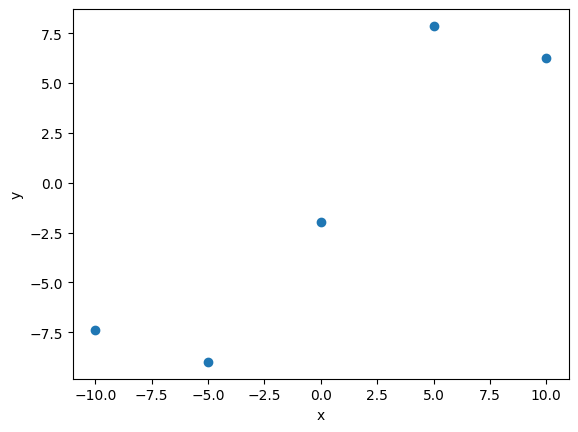

In [15]:
theta_true = 1 # az egyenesünk egy darab paramétere
beta_true = 1 # az egyenesünk egy darab paramétere
sigma_true = 4 # a normál zaj standard deviációja
m = 5 # adatpontok száma
x = np.linspace(-10,10,m)
y = theta_true*x + beta_true + np.random.normal(0,sigma_true,m)

# egyenes ábrázolása
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 3.~ szigmoid függvény
- becsüld a szigmoid paramétereit (amplitudó, küszöb, slope + esetleg zaj), de zaj csak a kimeneten van.
- ha nehéz, akkor mondd azt, hogy mondjuk az emplitudót (vagy a slope-ot is) ismered
- hasonlitsd össze, hogy mit kapsz sima least square-rel.


In [16]:
def Normal(sigma, mu, y):
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(y - mu)**2/(2*sigma**2))

def create_prior_from(grid):
    grid_shape = np.array((np.array(grid)[:,1]-np.array(grid)[:,0])/np.array(grid)[:,2], dtype=int)
    return np.log(np.ones(grid_shape)/np.prod(grid_shape))

def bayesian_updating(x,y, prior, grid, assumed_true_mapping, probability=Normal):
    for x_i, y_i in zip(x,y):
        for el in np.ndenumerate(prior):
            idx = el[0]
            parameters = grid[:,0] + grid[:,2] * np.array(idx)
            epsilon = 1e-8  # ez azért kell, hogy ne vegyük 0nak a logritmusát..
            prior[idx] += np.log(probability(parameters[-1], assumed_true_mapping(x_i, *parameters[:-1]), y_i) + epsilon)
    unnorm_posterior = np.exp(prior-np.max(prior))
    posterior = unnorm_posterior / np.max(unnorm_posterior)
    return posterior

In [17]:
mapping = lambda x,theta,b: 1/(1+np.exp(-theta*(x-b)))
theta_true = 2.5
b_true = 2.5
sigma_true = .5

m = 10
x = np.linspace(-10,10,m)
y = mapping(x,theta_true,b_true) + np.random.normal(0,sigma_true,m)

grid = np.array([[0.1, 3, 0.1], [0, 3, 0.1], [0.1, 10, 0.1]])
prior = create_prior_from(grid)
posterior = bayesian_updating(x,y, prior, grid, mapping)
np.array(np.where(posterior==np.max(posterior))) * grid[:,2].reshape(-1,1) + grid[:,0].reshape(-1,1)

array([[2.8],
       [0.1],
       [0.5]])

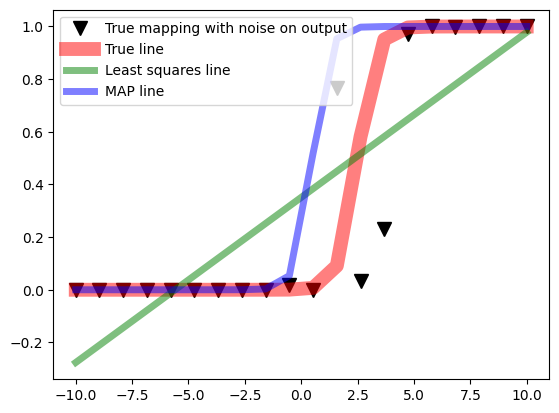

In [36]:
MAP = np.array(np.where(posterior==np.max(posterior))) * grid[:,2].reshape(-1,1) + grid[:,0].reshape(-1,1)
# fit a straight line with least squares
A = np.vstack([x, np.ones(len(x))]).T
theta, b = np.linalg.lstsq(A, y, rcond=None)[0]

plt.plot(x, y, 'v',c='black', label='True mapping with noise on output', markersize=10)
plt.plot(x, mapping(x,theta_true,b_true), 'r', label='True line', linewidth=10, alpha=.5)
plt.plot(x, x*theta+b, 'g', label='Least squares line', linewidth=5,alpha=.5)

# plot the baysian MAP result
plt.plot(x, mapping(x,MAP[0],MAP[1]), 'b', label='MAP line', linewidth=5,alpha=.5)

plt.legend()
plt.show()

#### 4.~ szigmoid függvény, zaj a bemeneten
- becsüld a szigmoid paramétereit (amplitudó, küszöb, slope + zaj), de zaj csak a bemeneten van.
- ha nehéz, akkor mondd azt, hogy mondjuk az emplitudót (vagy a slope-ot is) ismered
- hasonlitsd össze, hogy mit kapsz sima least square-rel.

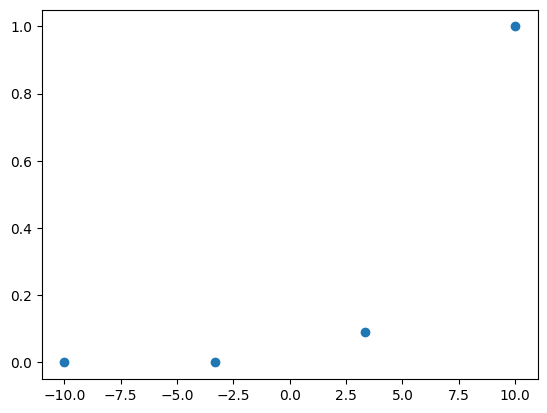

In [76]:
mapping = lambda x,theta,b: 1/(1+np.exp(-theta*(x-b)))
mapping_inv = lambda x, theta, b : -(np.log(1/x-1)-theta*b)/theta
theta_true = 2.5
b_true = 2.5
sigma_true = 2

m = 4
x = np.linspace(-10,10,m)
y = mapping(x + np.random.normal(0,sigma_true,m),theta_true,b_true)
plt.scatter(x,y)
plt.show()

In [77]:
def bayesian_updating_for_input_noise(x,y, prior, grid):
    for x_i, y_i in zip(x,y):
        for el in np.ndenumerate(prior):
            idx = el[0]
            parameters = grid[:,0] + grid[:,2] * np.array(idx)
            epsilon = 1e-8
            prior[idx] += np.log(Normal(parameters[-1], mapping_inv(y_i, *parameters[:-1]), x_i) + epsilon) # az előzőhöz képest a likelihodd kicsit módosult.
    unnorm_posterior = np.exp(prior-np.max(prior))
    posterior = unnorm_posterior / np.max(unnorm_posterior)
    return posterior

In [78]:
grid = np.array([[0.1, 3, 0.1], [0, 3, 0.1], [0.1, 10, 0.1]])
prior = create_prior_from(grid)
posterior = bayesian_updating_for_input_noise(x,y, prior, grid)
np.array(np.where(posterior==np.max(posterior))) * grid[:,2].reshape(-1,1) + grid[:,0].reshape(-1,1)

array([[2.7],
       [2.1],
       [1.2]])

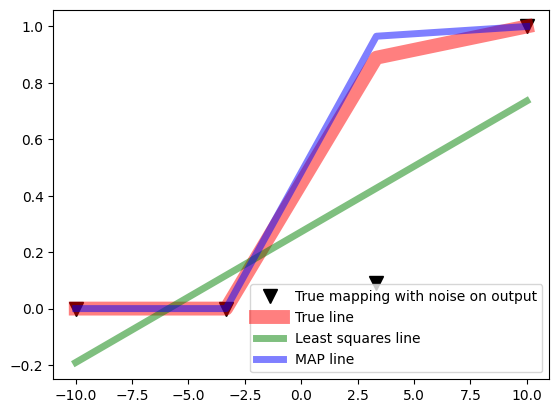

In [79]:
MAP = np.array(np.where(posterior==np.max(posterior))) * grid[:,2].reshape(-1,1) + grid[:,0].reshape(-1,1)
# fit a straight line with least squares
A = np.vstack([x, np.ones(len(x))]).T
theta, b = np.linalg.lstsq(A, y, rcond=None)[0]

plt.plot(x, y, 'v',c='black', label='True mapping with noise on output', markersize=10)
plt.plot(x, mapping(x,theta_true,b_true), 'r', label='True line', linewidth=10, alpha=.5)
plt.plot(x, x*theta+b, 'g', label='Least squares line', linewidth=5,alpha=.5)

# plot the baysian MAP result
plt.plot(x, mapping(x,MAP[0],MAP[1]), 'b', label='MAP line', linewidth=5,alpha=.5)

plt.legend()
plt.show()

#### 5.~ szigmoid függvény, zaj a bemeneten és a kimeneten is

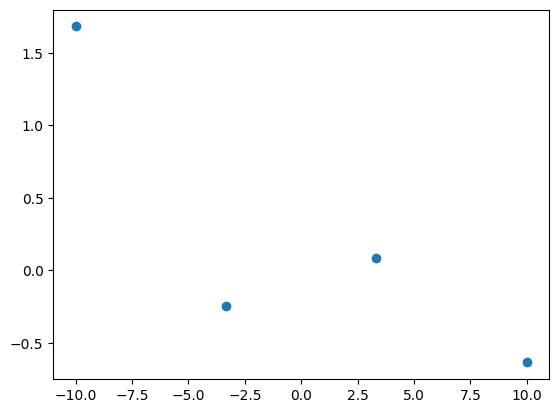

In [125]:
mapping = lambda x,theta,b: 1/(1+np.exp(-theta*(x-b)))
mapping_inv = lambda x, theta, b : -(np.log(1/x-1)-theta*b)/theta
theta_true = 2.5
b_true = 2.5
sigma_true_1 = 2.4
sigma_true_2 = 1.3

m = 4
x = np.linspace(-10,10,m)
y = mapping(x + np.random.normal(0,sigma_true_1,m),theta_true,b_true) + np.random.normal(0,sigma_true_2,m)
plt.scatter(x,y)
plt.show()

In [145]:
def bayesian_updating_for_input_and_output_noise(x,y, prior, grid):
    for x_i, y_i in zip(x,y):
        for el in np.ndenumerate(prior):
            idx = el[0]
            parameters = grid[:,0] + grid[:,2] * np.array(idx)
            likelihood = 0
            for x_ii in np.random.normal(mapping(x_i, *parameters[:-2]),parameters[-2], 10): # 10 mintavételezési pont
              # ez itt kicsit megbukik, mert előfordul, hogy nem invertálható a kimeneti zaj miatt, egyenlőre átugrom ezeket az eseteket..
              if (1/y_i-1) > 0:
                likelihood += Normal(parameters[-1], mapping_inv(y_i, *parameters[:-2]), x_i) * Normal(parameters[-2],mapping(x_ii, *parameters[:-2]), y_i)
            prior[idx] += np.log(likelihood + 1e-8)
    unnorm_posterior = np.exp(prior-np.max(prior))
    posterior = unnorm_posterior / np.max(unnorm_posterior)
    return posterior

In [147]:
grid = np.array([[0.1, 3, 0.3], [0.1, 3, 0.3], [0.1, 4, 0.3], [0.1, 4, 0.3]])
prior = create_prior_from(grid)
posterior = bayesian_updating_for_input_and_output_noise(x,y, prior, grid)
np.array(np.where(posterior==np.max(posterior))) * grid[:,2].reshape(-1,1) + grid[:,0].reshape(-1,1)

array([[2.2],
       [2.5],
       [0.1],
       [1.9]])

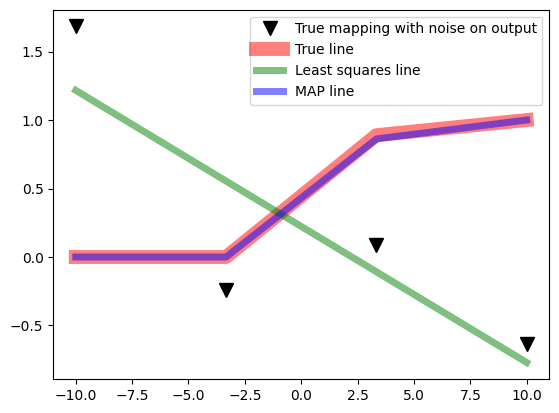

In [148]:
MAP = np.array(np.where(posterior==np.max(posterior))) * grid[:,2].reshape(-1,1) + grid[:,0].reshape(-1,1)
# fit a straight line with least squares
A = np.vstack([x, np.ones(len(x))]).T
theta, b = np.linalg.lstsq(A, y, rcond=None)[0]

plt.plot(x, y, 'v',c='black', label='True mapping with noise on output', markersize=10)
plt.plot(x, mapping(x,theta_true,b_true), 'r', label='True line', linewidth=10, alpha=.5)
plt.plot(x, x*theta+b, 'g', label='Least squares line', linewidth=5,alpha=.5)

# plot the baysian MAP result
plt.plot(x, mapping(x,MAP[0],MAP[1]), 'b', label='MAP line', linewidth=5,alpha=.5)

plt.legend()
plt.show()

## Egyéb